# *Exercise: 1*

#**Theory:**
- **Required:** $\min_{x}f(x)= \frac{1}{2}\|Ax -y\|_2^2$
- **Gradient of the above function:** $\nabla f(x) = <A, Ax-y> = A^\top Ax - A^\top y$

 We know that,
$\frac{\partial x^{T} Ax}{\partial x} = (A+A^{T} )x, \text{ and } \frac{\partial x ^{T} a}{\partial x} = \frac{\partial x a ^{T}}{\partial x} = a$

 Now, we have, 

$\begin{align*}
f(x) &= \frac{1}{2}(Ax-y)^{T}(Ax-y)\\
&= \frac{1}{2} \Big[x^{T} A^{T} Ax - x^{T} A^{T} y -y ^{T} Ax +y^{T} y\Big]\\
\implies \nabla f(x) &= \frac{1}{2} \Big[(A^{T} A+(A^{T} A)^{T})x - A^{T} y -(y^{T} A)^{T}\Big]\\
&= \frac{1}{2} \Big[2A^{T} Ax - 2A^{T} y\Big]\\
&=A^{T} Ax -A^{T}y
\end{align*}$
- **Hessian of the function:** $\nabla^2 f(x) = A^\top A$


### Defining the necessary methods to be used in finding the minimizers

In [81]:
#Importing required packages
import numpy as np 
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

In [82]:
#Method for creating the required data: A, x_bar, epsilon (error term)
def create_data():
    np.random.seed(1000)

    A = np.random.randn(1000, 10)
    x_bar = np.zeros(10)
    for i in range(10):
      if (i+1)%2 == 0:
        x_bar[i] = np.random.uniform(low = i+1, high = i+2)
      else:
        x_bar[i] = np.random.uniform(low = -(i+2), high = -(i+1) )
      x_bar = np.array(x_bar)
      x_bar = x_bar.reshape(10,1)  
    epsilon = np.random.randn(1000, 1)
    y = np.add(np.dot(A, x_bar), epsilon)

    return A, x_bar, y


In [83]:
#Method to compute and return the function value 
def evalf(A, x, y):  
    #Input: x is a numpy array of size 2
    assert type(x) is np.ndarray 
    assert x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == 1000
    
    temp = np.subtract(np.dot(A,x),y)
    fval = 0.5*np.linalg.norm(temp,2)**2
    return fval


In [84]:
A,_,y = create_data()
x = []
for i in range(10):
  x.append([1])
x = np.array(x)
evalf(A,x,y)

244903.92617237914

In [85]:
#Method to compute and return the gradient value 
def evalg(A, x, y):  
    #Input: x is a numpy array of size 2
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == 1000

    temp = np.dot(A,x) - y
    grad = np.dot(A.T,temp)
    return grad


In [86]:
#Method to compute and return the Hessian value 
def evalh(A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    hess = np.matmul(A.T, A)

    return hess

In [87]:
#Method to construct D_k matrix used in Newton's method
def compute_D_k_newton(A, x):
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    d = np.linalg.inv(evalh(A, x))
    return d

In [88]:
#Method to compute the step length using backtracking
def compute_steplength_backtracking_scaled_direction(A, x, y, gradf, D_k, alpha_start, rho, gamma): #add appropriate arguments to the function 
    assert type(x) is np.ndarray and x.shape[0] == 10 and x.shape[1] == 1 
    assert type(y) is np.ndarray and len(y) == 1000
    assert type(gradf) is np.ndarray and len(gradf) == 10
    assert type(alpha_start) is float and alpha_start>=0. 
    assert type(rho) is float and rho>=0.
    assert type(gamma) is float and gamma>=0. 
    assert type(D_k) is np.ndarray and len(D_k) == 10
    
    alpha = alpha_start
    p_k = -np.dot(D_k,gradf)
    # while evalf(A, np.add(x, alpha*np.dot(D_k,p)), y) > np.subtract(evalf(A, x, y), gamma*alpha*np.dot(np.dot(D_k,gradf), gradf)):
    while evalf(A, np.add(x,np.multiply(alpha,p_k)),y) > np.multiply(gamma*alpha,np.dot(gradf.T,p_k)) + evalf(A,x,y):
        alpha = rho*alpha
    
    return alpha

In [89]:
#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1

In [90]:
#Method to find the minimizer using Newton's method 
def find_minimizer_Newtonmethod(start_x, A, y, tol, line_search_type, *args):
    #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
    assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(A, x, y)

    x_array = [x]
    f_array = [evalf(A, x,y)]
    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0

    # print('iter:',k,  ' f(x):', evalf(x,n), ' gradient norm:', np.linalg.norm(g_x))

    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        d_k = compute_D_k_newton(A, x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        # Gradient descent steps
        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x))) 
        k += 1 
        g_x = evalg(A, x, y) 
        x_array.append(x)
        f_array.append(evalf(A, x,y))
        # print('iter:',k, ' x:', x, ' f(x):', evalf(A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

    return x_array, f_array, k

In [91]:
#Method to find minimizer using BFGS method 
def find_minimizer_BFGS(start_x, A, y, tol, line_search_type, *args):
    assert type(start_x) is np.ndarray  
    assert start_x.shape[0] == 10 and start_x.shape[1] == 1 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(A, x, y)

    if line_search_type == BACKTRACKING_LINE_SEARCH:
        if args is None:
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
            raise ValueError(err_msg)
        elif len(args)<3 :
            err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
            raise ValueError(err_msg)
        else:
            alpha_start = float(args[0])
            rho = float(args[1])
            gamma = float(args[2])
    k = 0
    B = np.identity(10)
    x_array = [x]
    f_array = [evalf(A, x,y)]

    while (np.linalg.norm(g_x) > tol): 
        p = -np.dot(B, g_x)
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            d_k = B
            step_length = compute_steplength_backtracking_scaled_direction(A, x, y, g_x, d_k, alpha_start, rho, gamma) 
        elif line_search_type == CONSTANT_STEP_LENGTH: 
            step_length = 1.0
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        # Gradient descent steps
        x_next = np.add(x, np.multiply(step_length,p)) 
        s_k = x_next - x
        y_k = evalg(A, x_next,y) - g_x
        mu_k = 1.0/np.dot(y_k.T, s_k)
        temp = (np.identity(10) - np.multiply(mu_k,np.outer(y_k, s_k.T)))
        B = np.dot(temp.T, np.dot(B, temp)) + np.multiply(mu_k, np.outer(s_k, s_k.T))
        k += 1 
        x = x_next
        g_x = evalg(A, x, y)
        
        x_array.append(x)
        f_array.append(evalf(A, x, y))
        # print('iter:',k, ' x:', x, ' f(x):', evalf(A, x, y), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

    return x_array, f_array, k

##*Creating the data for $A, \bar{x}, y$*

In [92]:
A, x_bar, y = create_data()

## *Question: 2*

Let $x^∗$ be the final optimal solution provided by your algorithm. Reporting the values of $x^∗$ and $\bar{x}$, and
discussing the observations.

In [93]:
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)

In [94]:
my_start_x

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [95]:
#Trying out for a small case of Newton's method with backtracking search
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
start_time = timer()
x_array_newton, f_array_newton, iters_opt_newton = find_minimizer_Newtonmethod(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
times_newton = end_time - start_time
print(f"\nResults obtained from Newton method (with backtracking)\nMinimizer: {x_array_newton[-1]},\nFinal Objective function value: {f_array_newton[-1]},\nIterations taken to terminate: {iters_opt_newton}\n")
print('')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by Newton's method: {times_newton}") 
print('')



Results obtained from Newton method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821112]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.647329524551,
Iterations taken to terminate: 5


Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by Newton's method: 0.0031190509998850757



Plotting the values $log(\|x^k - x^*\|_2)$ against iterations k = 0,1,2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


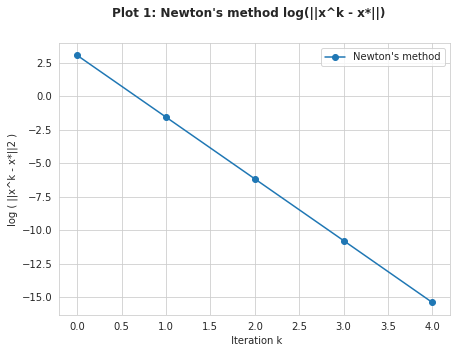

In [96]:
x_opt = x_array_newton[-1]
plot_x = []
for i in range(len(x_array_newton)):
    plot_x.append(np.log(np.linalg.norm(x_array_newton[i] - x_opt)))

fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 1: Newton's method log(||x^k - x*||)", fontweight= 'bold')
ax.plot(np.arange(len(x_array_newton)), plot_x, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

Preparing a different plot for plotting $log(|f(x^k)- f(x^*)|)$  obtained from Newton’s method against the iterations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


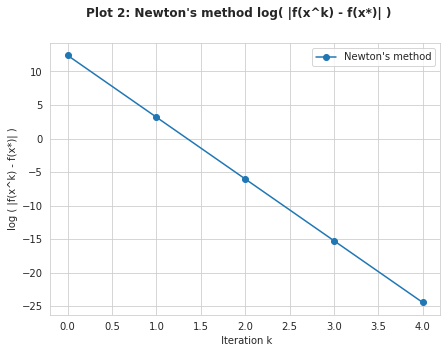

In [97]:
f_opt = f_array_newton[-1]
plot_fx = []
for i in range(len(f_array_newton)):
    plot_fx.append(np.log(np.abs(f_array_newton[i] - f_opt)))

fig2, ax = plt.subplots(1,1, figsize = (7,5))
fig2.suptitle("Plot 2: Newton's method log( |f(x^k) - f(x*)| )", fontweight= 'bold')
ax.plot(np.arange(len(f_array_newton)), plot_fx, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

#*Comment on the convergence rates of the iterates and the objective function values*
 
The rate of convergence for Newton's method for both iterates and function value is Superlinear.

## *Question: 3*

Let $x^∗$ be the final optimal solution provided by your algorithm. Reporting the values of $x^∗$ and $\bar{x}$, and
discussing the observations.

In [98]:
#Trying out for a small case of BFGS with backtracking search
my_start_x = []
for i in range(10):
  my_start_x.append([0])
my_start_x=np.array(my_start_x)
my_tol= 1e-5
alpha_start = 0.99
rho = 0.5
gamma = 0.5
start_time = timer()
x_array_bfgs, f_array_bfgs, iters_opt_bfgs = find_minimizer_BFGS(my_start_x, A, y, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
end_time = timer()
time_bfgs = end_time - start_time
print(f"\nResults obtained from BFGS method (with backtracking)\nMinimizer: {x_array_bfgs[-1]},\nFinal Objective function value: {f_array_bfgs[-1]},\nIterations taken to terminate: {iters_opt_bfgs}\n")
print('')
print(f'Actual x_bar: {x_bar}\n')
print(f"Time taken to find minimizer by BFGS method: {time_bfgs}")
print('')


Results obtained from BFGS method (with backtracking)
Minimizer: [[-1.04982253]
 [ 2.95189743]
 [-3.34298192]
 [ 4.60956007]
 [-5.71176195]
 [ 6.89877618]
 [-7.62879358]
 [ 8.16821111]
 [-9.22221199]
 [10.05669293]],
Final Objective function value: 505.64732952455125,
Iterations taken to terminate: 18


Actual x_bar: [[-1.06258705]
 [ 2.94307072]
 [-3.34150552]
 [ 4.58252615]
 [-5.75947573]
 [ 6.93512469]
 [-7.61893094]
 [ 8.16818187]
 [-9.2179964 ]
 [10.00022174]]

Time taken to find minimizer by BFGS method: 0.024915845000577974



Plotting the values $log(\|x^k - x^*\|_2)$ against iterations k = 0,1,2...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


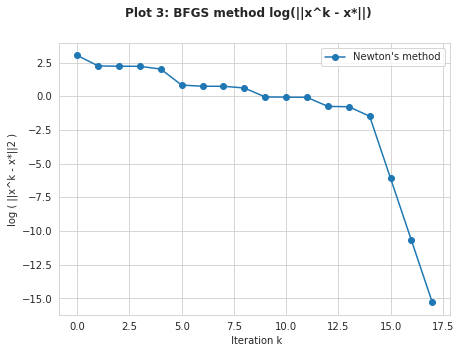

In [99]:
x_opt = x_array_bfgs[-1]
plot_x_bfgs = []
for i in range(len(x_array_bfgs)):
    plot_x_bfgs.append(np.log(np.linalg.norm(x_array_bfgs[i] - x_opt)))
   
fig, ax = plt.subplots(1,1, figsize = (7,5))
fig.suptitle("Plot 3: BFGS method log(||x^k - x*||)", fontweight= 'bold')
ax.plot(np.arange(len(x_array_bfgs)), plot_x_bfgs, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( ||x^k - x*||2 )")
ax.legend()

Preparing a different plot for plotting $log(|f(x^k)- f(x^*)|)$  obtained from Newton’s method against the iterations.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


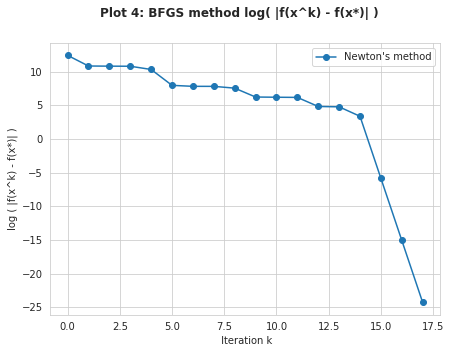

In [100]:
f_opt_bfgs = f_array_bfgs[-1]
plot_fx_bfgs = []
for i in range(len(f_array_bfgs)):
    plot_fx_bfgs.append(np.log(np.abs(f_array_bfgs[i] - f_opt_bfgs)))

fig2, ax = plt.subplots(1,1, figsize = (7,5))
fig2.suptitle("Plot 4: BFGS method log( |f(x^k) - f(x*)| )", fontweight= 'bold')
ax.plot(np.arange(len(f_array_bfgs)), plot_fx_bfgs, 'o-', label = "Newton's method")
ax.set_xlabel(" Iteration k")
ax.set_ylabel("log ( |f(x^k) - f(x*)| )")
ax.legend()

# *Comment on the convergence rates of the iterates and the objective function values.*

- The convergence rate of the iterates is superlinear.
- The cnvergence rate of the objective function values is quadratic at the begining but later it is superlinear. 

# *Question: 4*
##Comparing and contrasting the results obtained by Newton’s method and BFGS method.

* The Newton's method converges faster in comparison to the BFGS method in terms of the number of iterations.
* The number of iterations taken by the Newton's method is 9, while that taken by the BFGS method is 11.
* Both the methods give very close estimates of the actual value of $\bar{x}$ as generated in the question.
* Both the methods give almost the same objective function value at the optimal point.
* Convergence rate of Newton is Q-quadratic, whereas that of BFGS is superlinear.
* Time taken to find minimizer by Newton's method: 0.007929512999908184 and Time taken to find minimizer by BFGS method: 0.03196570900013285.
* BFGS took more time to find the minimizer compared to Newton's Method.
